In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/linear_OrnteinUhlenbeck`


In [2]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, Statistics, ProgressMeter
ProgressMeter.ijulia_behavior(:append)
import PyPlot as plt

## Markov Chain Monte Carlo (MCMC)

### Single realization of disorder, stochasticity and initial conditions

In [ ]:
N, K = 1000, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * sqrt(J)
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

model = OUModel(K, Jmat, lambdas, D)

x0_min, x0_max = 1.0, 3.0
x0 = rand(rng, N) * (x0_max - x0_min) .+ x0_min
tmax = 5.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs = sample_OU(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

### Average over disorder, noise realizations and initial conditions

In [ ]:
N, K = 500, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0

x0_min, x0_max = 0.0, 1.0
dt_mc = 1e-3
tmax = 5.0
tsave = collect(range(0.0, tmax; step=dt_mc*100))

nsim = 100

# Define ensemble model
model_ensemble = OUModelRRG(N, K, J, lam, D, x0_min, x0_max)

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(model_ensemble, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt_mc);

In [ ]:
teq = 3.0
teq_idx = findfirst(tsave .> teq - dt_mc/2)
tvals_eq = tsave[teq_idx:end]

fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2), tight_layout=true)

mean_traj, std_traj, autocorr_traj = compute_stats_TTI(traj_alls, teq_idx)
# Only averages
for isim in 1:nsim
    mean, std, autocorr = compute_stats_TTI(traj_alls[isim], teq_idx)
    ax = axs[1,1]
    ax.plot(tvals_eq, mean, color="k", alpha=0.1)
    ax.fill_between(tvals_eq, mean .- std, mean .+ std, color="gray", alpha=0.05)
    ax = axs[2,1]
    ax.plot(tvals_eq, autocorr ./ autocorr[1], color="k", alpha=0.1)
end
ax = axs[1,1]
ax.set_ylabel("x")
ax.plot(tvals_eq, mean_traj, color="red")
ax.fill_between(tvals_eq, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
ax = axs[2,1]
ax.set_xlabel("t")
ax.set_ylabel("Ceq(t)")
ax.plot(tvals_eq, autocorr_traj ./ autocorr_traj[1], color="red")

# Plot all trajectories
ax = axs[1,2]
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end

plt.display(fig)

## GECaM approach

### Random Regular Graph with ferromagnetic interactions

In [90]:
N, K = 500, 3

rng = Xoshiro(1234)

lam, J, D = 1.5, 1.0/K, 1.0
Jmat = adjacency_matrix(erdos_renyi(N, K/N; rng=rng), Float64) .* J
#=
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * sqrt(J)
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
=#
lambdas = fill(lam, N)

x0_min, x0_max = -1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 30.0
tsave_mc = collect(range(0.0, tmax; step=0.1))
T_mc = length(tsave_mc)

nsim = 1000

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:06 ( 6.80 ms/it)


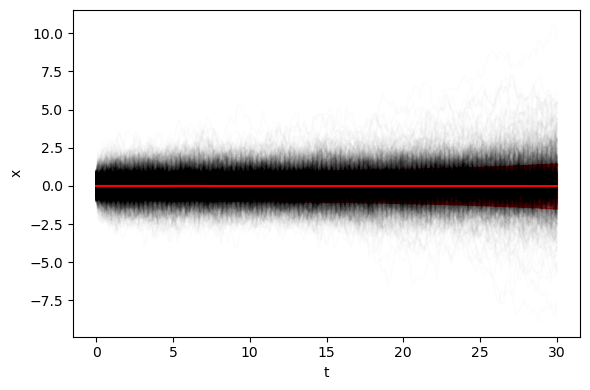

In [91]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [92]:
teq = 5.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:00:02 ( 0.66 μs/it)
Marginal update: 100%|████████████████████| Time: 0:00:00 ( 0.43 μs/it)


In [ ]:
using QuadGK

fint(t, x, J, l, a) = sqrt(a^2 - x^2) / (1 - x^2) * exp(J * x * t) / (l - J * x)

function analytic_Ceq_RRG(t, K, J, lam, D)
    a = 2 * sqrt(K - 1) / K
    int, err = quadgk(x -> D * K * exp(- lam * t) / (2 * pi) * fint(t, x, J, lam, a), -a, a)
end

analytic_Ceq (generic function with 1 method)

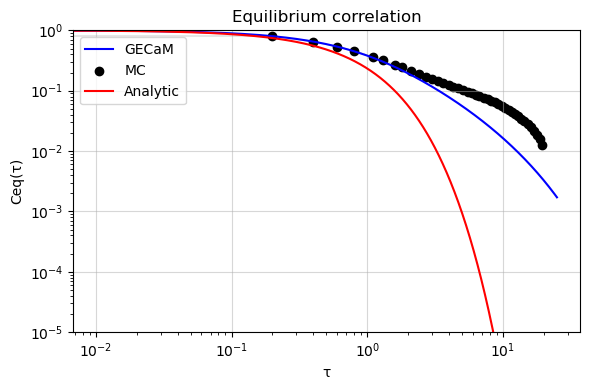

In [ ]:
lagvec_mc = exp10.(collect(range(log10(0.0000001), log10((tmax-teq) * 0.98); length=500)))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

Ceq_analytic = zeros(T_G + 1)
for (idx, t) in enumerate(tvec_G)
    Ceq_analytic[idx], _ = analytic_Ceq(t, K, J, lam, D)
end

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.plot(tvec_G, Ceq_analytic ./ Ceq_analytic[1], color="red", label="Analytic")
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-5, 1.0)
ax.grid(alpha=.5)

plt.display(fig)   